# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
#import mlutils
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

## Leer el dataset

### Train

Datos de entrenamiento: este data set (df_completo) será dividido en datos de entrenamiento y datos de testeo para entrenar el modelo de predicción.

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo. 

In [4]:
# URL del archivo .csv en el repositorio de GitHub
#Cargamos archivo de entrenamiento
url = "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_train-labeled.csv"

# Leer el archivo .csv desde la URL
df_completo = pd.read_csv(url) #Tiene el archivo de entrenamiento

# Mostrar las primeras filas del DataFrame


In [5]:
print(df_completo.shape)


(95000, 10)


In [6]:
df_completo.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


In [7]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


**Descripción de las variables del datsa set**

Contamos con un total de 9 features y la variable objetivo: *diabetes*.

Dentro de las variables independientes tenemos 2 features categóricas y 7 features numéricas. Las mismas se definen de la siguiente manera:

- patient: id del paciente.

- gender: Se refiere al sexo biológico del individuo, que puede tener un impacto en su susceptibilidad a la diabetes. En él se distinguen tres categorías: masculino, femenino y otro.

- age: La edad es un factor importante, ya que la diabetes se diagnostica con más frecuencia en adultos mayores.

- hypertension: es una condición médica en la que la presión sanguínea en las arterias es persistentemente elevada. Tiene valores a 0 o 1 donde 0 indica que no tienen hipertensión y 1 significa que tienen hipertensión.

- heart_disease: otra condición médica que se asocia con un mayor riesgo de desarrollar diabetes. Tiene valores a 0 o 1 donde 0 indica que no tienen enfermedad cardiaca y para 1 significa que tienen enfermedad cardiaca.

- smoking_history: historial de tabaquismo. Se considera un factor de riesgo para la diabetes y puede agravar las complicaciones asociadas a la diabetes. Cuenta con 5 categorías: no actual, anterior, sin información, actual, nunca y alguna vez.

- bmi: Índice de Masa Corporal, es una medida de la grasa corporal basada en el peso y la estatura. Los valores más altos de bmi están relacionados con un mayor riesgo de diabetes. El intervalo del bmi en el conjunto de datos va de 10,16 a 71,55. Un bmi inferior a 18,5 es bajo peso, de 18,5 a 24,9 es normal, de 25 a 29,9 es sobrepeso y 30 o más es obesidad.

- HbA1c_level: Hemoglobina A1c, es una medida del nivel medio de azúcar en sangre de una persona en los últimos 2-3 meses. Los niveles más altos indican un mayor riesgo de desarrollar diabetes. En la mayoría de los casos, un nivel de HbA1c superior al 6,5% indica diabetes.

- blood_glucose_level: nivel de glucosa en sangre. Se refiere a la cantidad de glucosa en el torrente sanguíneo en un momento dado. Los niveles altos de glucosa en sangre son un indicador clave de diabetes.

- diabetes: es la variable objetivo que se predice, con valores de 1 que indican la presencia de diabetes y 0 que indican la ausencia de diabetes.


**Valores faltanes**

Buscamos valores faltantes en las variables del dataset.

In [8]:
# Calcular el número de valores faltantes por columna
valores_faltantes = df_completo.isnull().sum()

# Filtrar las columnas que tienen al menos un valor faltante
columnas_con_faltantes = valores_faltantes[valores_faltantes > 0]

print(columnas_con_faltantes)

Series([], dtype: int64)


No contamos con valores faltantes en el data frame.

### Análisis de la distribución de cada feature

In [9]:
# Definimos 2 conjuntos segun variables numéricas y categóricas:
SampleColumns_cat = ['gender', 'smoking_history']

SampleColumns_num = ['patient', 'age', 'hypertension', 'heart_disease',
       'bmi', 'HbA1c_level', 'blood_glucose_level','diabetes']

**Análisis features categóricas**

Realizamos histogramas de las variables categóricas para observar la frecuencia de cada valor.

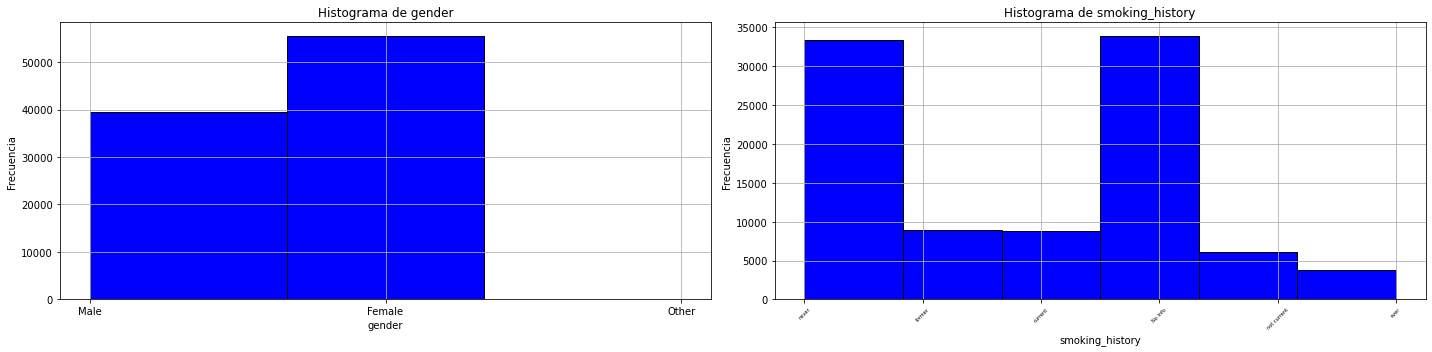

In [10]:
#Veamos histogramas de variables categoricas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for ax, column in zip(axes, SampleColumns_cat):
    num_bins = df_completo[column].nunique()  # Determinar el número de bins basado en valores únicos
    #if column == 'columna_3':  # Ajustar el número de bins específicamente para una columna
        #num_bins = 15  # Aquí especificas el número de bins que quieres para 'columna_3'
    ax.hist(df_completo[column], bins=num_bins, color='blue', edgecolor='black')
    ax.set_title(f'Histograma de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')
    ax.grid(True)

# Ajustar el layout para evitar superposiciones
plt.xticks(rotation = 45, fontsize=5)
plt.tight_layout()
plt.show()

**Análisis features numéricas**

Al igual que con las categoricas, observamos la distribución para el caso de variables númericas.

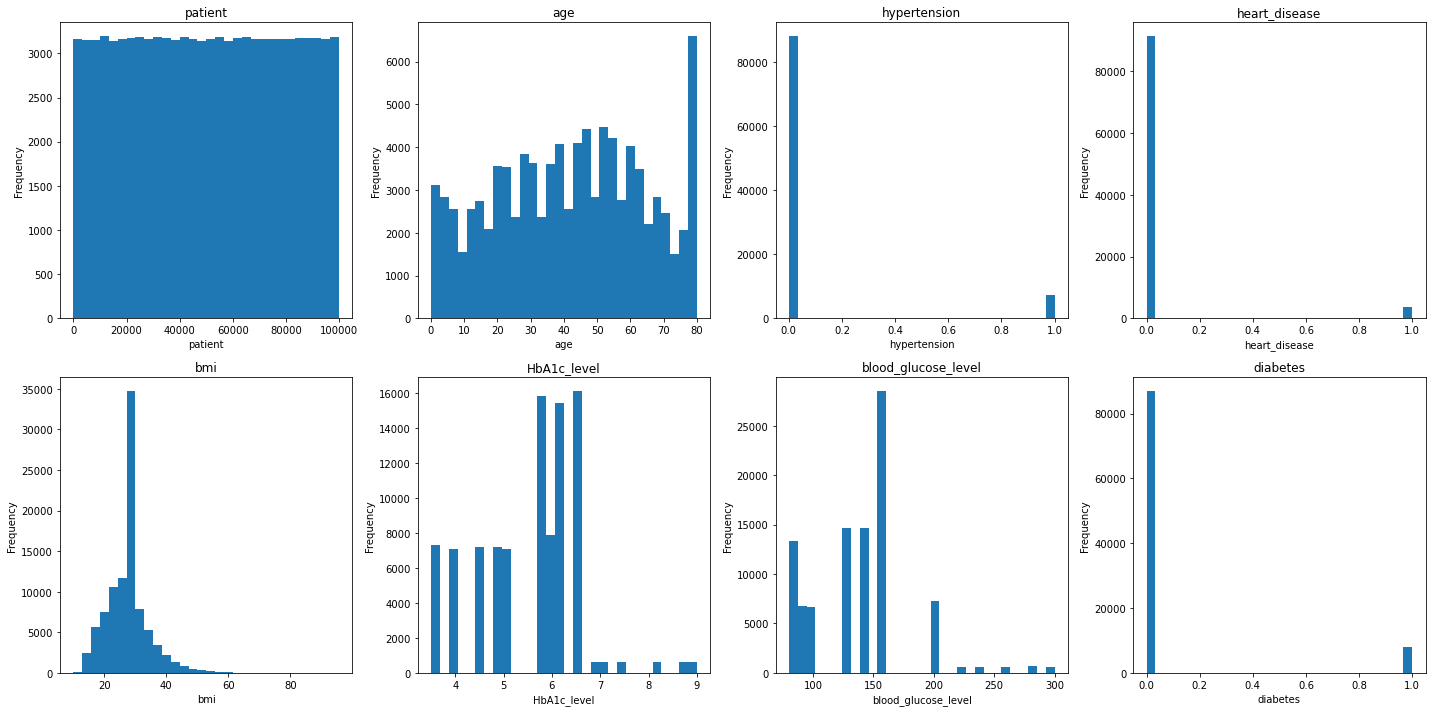

In [11]:
# Crear una figura con un diseño de 2 filas y 4 columnas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Aplanar la matriz de ejes para poder iterar fácilmente
axes = axes.flatten()

# Iterar sobre las columnas y los ejes para crear los histogramas
for i, col in enumerate(SampleColumns_num):
    df_completo[col].plot(kind='hist', ax=axes[i], title=col, bins=30)
    axes[i].set_xlabel(col)

# Ajustar el layout para que no haya solapamiento
plt.tight_layout()
plt.show()

**Descripción de los histogramas**
A partir de los graficos anteriores concluimos:

- patient: como es un identificador del paciente, tiene sentido que tenga una distribución homogenea. No será utilizado como variable predictiva.

- hypertension y heart_disease: presentan un desbalance notorio entre las clases. Para evitar su influencia en el modelo serán correctamente tratadas (estandarización).

- diabetes: la variable target presenta un gran desbalance. Esto si puede influenciar mucho en la predicción del modelo por lo que habrá que tenerlo en cuenta para la elección de los modelos o para su entrenamiento.

- En cuanto a las variables categóricas, las mismas serán "encodeadas".

In [12]:
df_completo.columns

Index(['patient', 'gender', 'age', 'hypertension', 'heart_disease',
       'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level',
       'diabetes'],
      dtype='object')

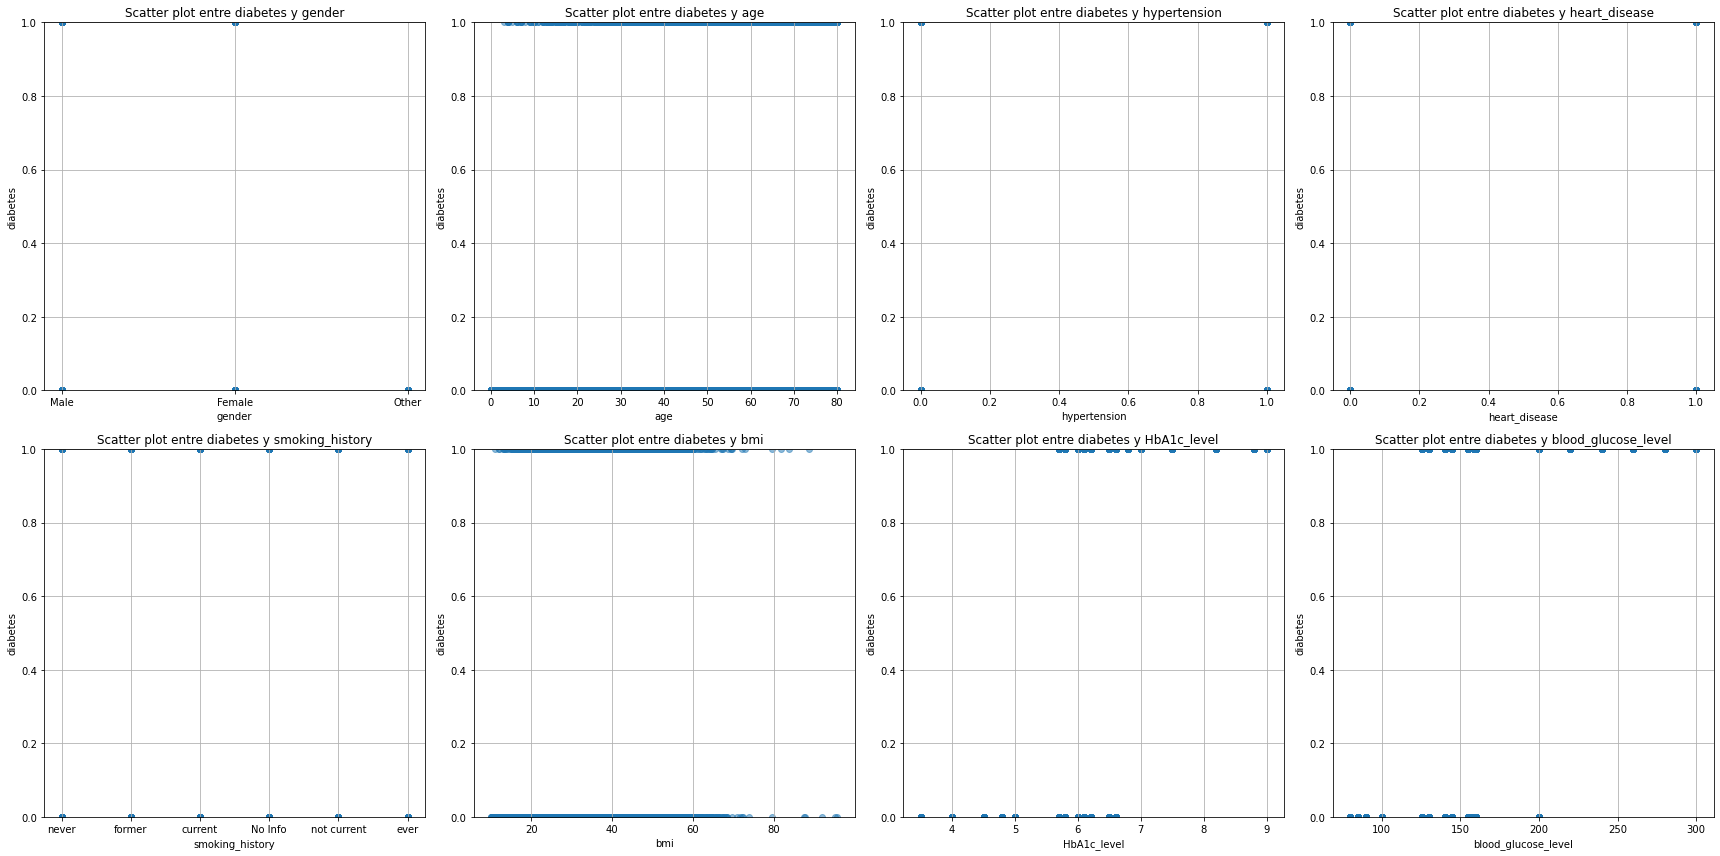

In [13]:
# Columna fija
fixed_column = 'diabetes'
# Lista de columnas seleccionadas
selected_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level']

# Crear una figura con subplots organizados en 2 filas y 4 columnas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

# Iterar sobre las columnas seleccionadas y hacer un scatter plot en cada subplot
for i, column in enumerate(selected_columns):
    row = i // 4  # Calcular la fila (0 o 1)
    col = i % 4   # Calcular la columna (0, 1, 2 o 3)
    
    axes[row, col].scatter(df_completo[column], df_completo[fixed_column], alpha=0.5)
    axes[row, col].set_title(f'Scatter plot entre {fixed_column} y {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel(fixed_column)
    axes[row, col].set_ylim(0, 1)  # Para poder visualizar la tendencia
    axes[row, col].grid(True)

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

## División en datos de entrenamiento y testeo 

Dividimos el df_completo en datos de entrenamiento (df_train) y datos de testeo (df_test). Es necesario hacer esto previo al encoding y estadarización para evitar el data leakage.

In [14]:
# Guardamos la columna patient en una variable separada y la eliminamos del data frame.
patientId = df_completo.patient
df_completo.drop('patient',axis=1,inplace=True)

In [15]:
# Definimos variables de entrenamiento
X = df_completo.drop(['diabetes'],axis=1)
y = df_completo['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**Encoding variables categóricas** 

In [16]:
# Crear una instancia de OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Ajustar y transformar el DataFrame diferencian en train y test
encoded = ohe.fit_transform(X_train[['gender', 'smoking_history']])
encoded_test = ohe.transform(X_test[['gender', 'smoking_history']])

In [17]:
# Convertir el resultado a un DataFrame
df_train_cat = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['gender', 'smoking_history']))
df_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out(['gender', 'smoking_history']))
print("\nDataFrame codificado:")
print(df_test_cat)


DataFrame codificado:
       gender_Female  gender_Male  gender_Other  smoking_history_No Info  \
0                1.0          0.0           0.0                      0.0   
1                0.0          1.0           0.0                      0.0   
2                1.0          0.0           0.0                      0.0   
3                1.0          0.0           0.0                      1.0   
4                0.0          1.0           0.0                      0.0   
...              ...          ...           ...                      ...   
28495            0.0          1.0           0.0                      0.0   
28496            1.0          0.0           0.0                      1.0   
28497            0.0          1.0           0.0                      0.0   
28498            1.0          0.0           0.0                      1.0   
28499            1.0          0.0           0.0                      0.0   

       smoking_history_current  smoking_history_ever  smoking_hi

Como resultado tenemos dos data frames (df_train_cat y df_test_cat) con las variables categóricas encodeadas. Creamos un dta frame de variables númericas, eliminando las categoricas sin encodear para realizar la estandarización.

Una vez hecho esto concatenaremos los data frame (categoricas encodeadas y númericas estandarizadas).

In [18]:
# Data frame de variables numéricas

df_test_num = X_test.drop(["gender","smoking_history"], axis=1)

df_train_num = X_train.drop(["gender","smoking_history"], axis=1)

**Estandarización variables numéricas**

Estandarizamos aquellas variables que no tienen como categoria 0 o 1. Tampoco estandarizamos variables categoricas encodeadas.

In [19]:
# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Columnas a estandarizar
cols_to_scale = ['age', 'bmi', 'HbA1c_level','blood_glucose_level']

# Ajustar el scaler solo con las columnas seleccionadas
scaler.fit(df_train_num[cols_to_scale])

# Transformar solo las columnas seleccionadas y reemplazar en el DataFrame
df_train_num[cols_to_scale] = scaler.transform(df_train_num[cols_to_scale])
df_test_num[cols_to_scale] = scaler.transform(df_test_num[cols_to_scale])


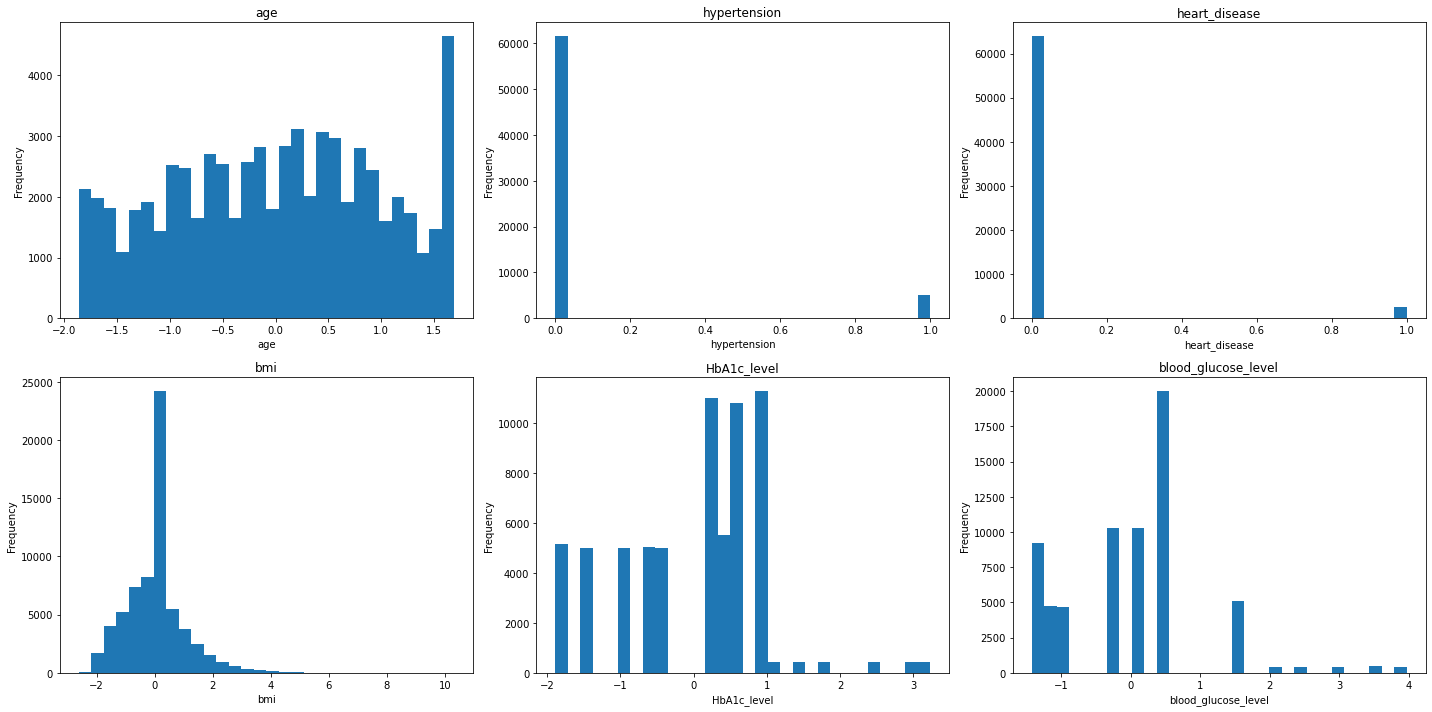

In [20]:
# Crear una figura con un diseño de 2 filas y 4 columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Aplanar la matriz de ejes para poder iterar fácilmente
axes = axes.flatten()

# Iterar sobre las columnas y los ejes para crear los histogramas
for i, col in enumerate(df_train_num.columns):
    df_train_num[col].plot(kind='hist', ax=axes[i], title=col, bins=30)
    axes[i].set_xlabel(col)

# Ajustar el layout para que no haya solapamiento
plt.tight_layout()
plt.show()

Creamos los data frame de entrenamiento y testeo con variables categoricas encodeadas y variables númericas estandarizadas (salvo las binarias). Este data set será el utilizado para entrenar los modelos y compararlos.

In [21]:
df_test_num

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
43450,-1.020674,0,0,-0.277978,-0.678379,-0.299509
14791,1.243165,1,0,-0.294577,2.490333,-0.201360
28617,0.177829,0,0,1.339715,0.160398,-1.182848
60875,1.420721,0,0,0.589721,0.253595,2.497732
50419,1.376332,1,0,0.425236,0.905977,-0.299509
...,...,...,...,...,...,...
73425,0.888053,0,1,0.072120,0.999175,0.044012
26488,-1.065063,0,0,0.001195,-1.423959,0.485682
31539,-0.177283,0,0,0.001195,-0.678379,-1.305534
13711,1.642666,0,0,0.939819,0.626385,1.516244


In [22]:
#Concatenamos variables númericas + categoricas
df_train_final = pd.concat([df_train_num.reset_index(drop=True), df_train_cat.reset_index(drop=True)], axis=1) 
df_test_final = pd.concat([df_test_num.reset_index(drop=True), df_test_cat.reset_index(drop=True)], axis=1)

La columna ***`diabetes`*** es la columna que debemos predecir. En el dataset de validación esta columna tiene valores nulos.

### Validacion

Datos que usamos para validar el modelo ya entrenado

Cargamos los datos de validación. Estos datos son los que van a utilizar para predecir si las personas tienen diabetes y generar alrchivo `submision.csv` para utilizar en la competencia de Kaggle.

In [23]:
# URL del archivo .csv en el repositorio de GitHub
#Cargamos archivo de Validacion
url = "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_test.csv"

# Leer el archivo .csv desde la URL
df_validacion = pd.read_csv(url) #Tiene el archivo de entrenamiento

# Mostrar las primeras filas del DataFrame
#print(df_validacion.head())

In [24]:
df_validacion.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN


In [25]:
df_validacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              5000 non-null   int64  
 1   gender               5000 non-null   object 
 2   age                  5000 non-null   float64
 3   hypertension         5000 non-null   int64  
 4   heart_disease        5000 non-null   int64  
 5   smoking_history      5000 non-null   object 
 6   bmi                  5000 non-null   float64
 7   HbA1c_level          5000 non-null   float64
 8   blood_glucose_level  5000 non-null   int64  
 9   diabetes             0 non-null      float64
dtypes: float64(4), int64(4), object(2)
memory usage: 390.8+ KB


### Planteo de modelos
Tienen que elegir los 2 mejores modelos así que prueben con varios.

In [26]:
clfs = [DecisionTreeClassifier()] # Hicimos una prueba agregando:class_weight='balanced', random_state=42 pero no mejora
names = ['Árbol de decisión']

trained_models = []
accuracy_models = []

for clf,name in zip(clfs,names):
    print(name)
    clf.fit(df_train_final, y_train)
    train_predictions = clf.predict(df_train_final)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = clf.predict(df_test_final)
    accuracy = accuracy_score(y_test, test_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    #plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Árbol de decisión
Accuracy train Árbol de decisión: 99.93%
Accuracy test {name}: 95.20%


### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [27]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
  'min_samples_leaf':(1, 2, 5),
  'min_samples_split':(2, 3, 5, 10, 50, 100),
 'max_depth':(5,10,20)})
grid.fit(df_train_final,y_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

Accuracy train Arbol de decisión: 97.18%
Accuracy test Arbol de decisión: 97.18%


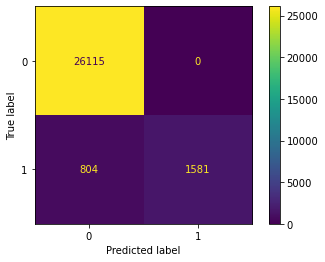

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     26115
           1       1.00      0.66      0.80      2385

    accuracy                           0.97     28500
   macro avg       0.99      0.83      0.89     28500
weighted avg       0.97      0.97      0.97     28500



In [28]:
clf = DecisionTreeClassifier(**grid.best_params_).fit(df_train_final, y_train)

train_predictions = clf.predict(df_train_final)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(df_test_final)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf.predict(df_test_final)))

In [29]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(df_train_final)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(max_depth=5)


Precisión test fold 0: 97.19
Precisión test fold 1: 97.24
Precisión test fold 2: 97.18
Precisión test fold 3: 97.07
Precisión test fold 4: 97.25
Avg. accuracy = 97.18496240601503


Accuracy train SVM sigmoid: 91.69%
Accuracy Test SVM sigmoid: 91.82%


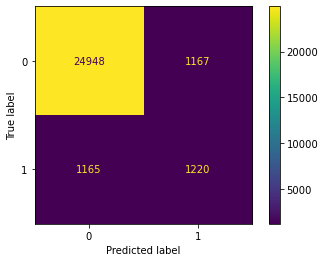

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     26115
           1       0.51      0.51      0.51      2385

    accuracy                           0.92     28500
   macro avg       0.73      0.73      0.73     28500
weighted avg       0.92      0.92      0.92     28500



In [35]:
from sklearn import svm
clf = sklearn.svm.SVC(kernel="sigmoid", gamma="auto").fit(df_train_final, y_train)
test_predictions = clf.predict(df_test_final)
train_predictions= clf.predict(df_train_final)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train SVM sigmoid: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy Test SVM sigmoid: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()
print(classification_report(y_test,clf.predict(df_test_final)))



Probamos con Kernel RBF

[LibSVM]Accuracy train SVM rbf: 96.37%
Accuracy Test SVM rbf: 96.44%


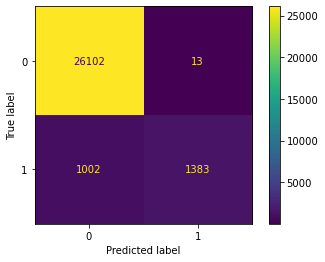

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26115
           1       0.99      0.58      0.73      2385

    accuracy                           0.96     28500
   macro avg       0.98      0.79      0.86     28500
weighted avg       0.97      0.96      0.96     28500



In [38]:
clf = sklearn.svm.SVC(kernel="rbf", gamma="auto", verbose=2).fit(df_train_final, y_train)
test_predictions = clf.predict(df_test_final)
train_predictions= clf.predict(df_train_final)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train SVM rbf: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy Test SVM rbf: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()
print(classification_report(y_test,clf.predict(df_test_final)))

Vemos con validación cruzada estratificada

[LibSVM]Accuracy fold: 89.26%
[LibSVM]Accuracy fold: 88.74%
[LibSVM]Accuracy fold: 88.73%
[LibSVM]Accuracy fold: 88.77%
[LibSVM]Accuracy fold: 88.26%
Mean Accuracy (CV): 88.75%
[LibSVM]Accuracy train SVM rbf: 88.84%
Accuracy test SVM rbf: 88.70%


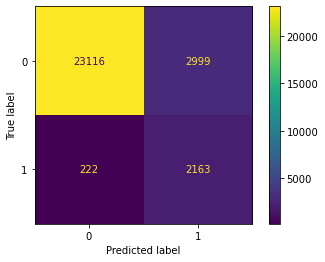

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     26115
           1       0.42      0.91      0.57      2385

    accuracy                           0.89     28500
   macro avg       0.70      0.90      0.75     28500
weighted avg       0.94      0.89      0.90     28500



In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Definir el modelo SVM con kernel RBF
clf = SVC(kernel="rbf", gamma="auto", class_weight='balanced', verbose=2)
n_splits = 5  # Número de pliegues para la validación cruzada

# Configuración de StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inicialización de listas para almacenar los resultados de validación cruzada
fold_accuracies = []

# Validación cruzada
for train_index, test_index in skf.split(df_train_final, y_train):
    X_train_fold, X_test_fold = df_train_final.iloc[train_index], df_train_final.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    clf.fit(X_train_fold, y_train_fold)
    
    # Predicción y cálculo de precisión en el conjunto de validación
    val_predictions = clf.predict(X_test_fold)
    fold_accuracy = accuracy_score(y_test_fold, val_predictions)
    fold_accuracies.append(fold_accuracy)
    
    print(f"Accuracy fold: %.2f%%" % (fold_accuracy * 100.0))

# Calcular y mostrar la precisión media de validación cruzada
mean_fold_accuracy = np.mean(fold_accuracies)
print(f"Mean Accuracy (CV): %.2f%%" % (mean_fold_accuracy * 100.0))

# Evaluación final en el conjunto de prueba completo
clf.fit(df_train_final, y_train)
train_predictions = clf.predict(df_train_final)
test_predictions = clf.predict(df_test_final)

# Cálculo de precisión en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train SVM rbf: %.2f%%" % (train_accuracy * 100.0))

# Cálculo de precisión en el conjunto de prueba
test_accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test SVM rbf: %.2f%%" % (test_accuracy * 100.0))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_test, test_predictions))


La precisión empeoró, lo cual nos habla de que este algoritmo no es óptimo para estos datos. Hacemos una prueba mas variando los hiperparámetros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LibSVM]Best hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy train SVM rbf: 91.30%
Accuracy test SVM rbf: 90.45%


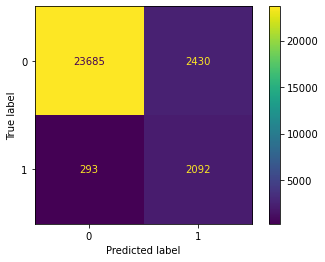

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     26115
           1       0.46      0.88      0.61      2385

    accuracy                           0.90     28500
   macro avg       0.73      0.89      0.78     28500
weighted avg       0.94      0.90      0.92     28500



In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Definir el rango de hiperparámetros para el grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

# Configuración de StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Definir el modelo SVM
svc = SVC(class_weight='balanced', verbose=2)

# Configuración de GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=skf, scoring='accuracy', verbose=2, n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(df_train_final, y_train)

# Mostrar los mejores hiperparámetros
print("Best hyperparameters:", grid_search.best_params_)

# Evaluación final en el conjunto de prueba completo
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(df_train_final)
test_predictions = best_model.predict(df_test_final)

# Cálculo de precisión en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train SVM rbf: %.2f%%" % (train_accuracy * 100.0))

# Cálculo de precisión en el conjunto de prueba
test_accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test SVM rbf: %.2f%%" % (test_accuracy * 100.0))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_test, test_predictions))


In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Definir los grados de los polinomios a probar
degrees = [2, 3, 4, 5]
n_splits = 5  # Número de pliegues para la validación cruzada

# Inicialización de listas para almacenar los resultados
trained_models = []
accuracy_models = []
mean_accuracies = {}

# Configuración de StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Función para plotear la frontera de decisión
def plot_decision_boundary(pred_func, X, y, resolution=0.01):
    # Crear un grid de todos los puntos en el rango de datos
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Predecir las clases para cada punto en el grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plotear el contour y los puntos de datos
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[0, :], X[1, :], c=y, s=20, edgecolor='k')
    plt.show()

for degree in degrees:
    clf = SVC(kernel='poly', degree=degree, class_weight='balanced')
    name = f'SVM Polinomial (Grado {degree})'
    print(name)
    
    fold_accuracies = []

    for train_index, test_index in skf.split(df_train_final, y_train):
        X_train_fold, X_test_fold = df_train_final.iloc[train_index], df_train_final.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        clf.fit(X_train_fold, y_train_fold)
        
        # Predicción y cálculo de precisión en el conjunto de validación
        val_predictions = clf.predict(X_test_fold)
        fold_accuracy = accuracy_score(y_test_fold, val_predictions)
        fold_accuracies.append(fold_accuracy)
    
    mean_fold_accuracy = np.mean(fold_accuracies)
    mean_accuracies[degree] = mean_fold_accuracy * 100.0
    print(f"Mean Accuracy (CV) {name}: %.2f%%" % (mean_fold_accuracy * 100.0))
    
    # Evaluación final en el conjunto de prueba completo
    clf.fit(df_train_final, y_train)
    test_predictions = clf.predict(df_test_final)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (test_accuracy * 100.0))
    
    trained_models.append(clf)
    accuracy_models.append(test_accuracy * 100)
    
    # Visualizar la frontera de decisión
    #X_test = df_test_final.values.T  # Asegúrate de que los datos estén en el formato correcto
    #y_test = y_test.values.T  # Asegúrate de que los datos estén en el formato correcto
    #plot_decision_boundary(lambda x: clf.predict(x), X_test, y_test)

# Imprimir resultados de todos los grados
for degree, accuracy in mean_accuracies.items():
    print(f"Grado {degree}: Mean Accuracy (CV) = {accuracy:.2f}%")


SVM Polinomial (Grado 2)
Mean Accuracy (CV) SVM Polinomial (Grado 2): 89.08%
Accuracy test SVM Polinomial (Grado 2): 89.09%
SVM Polinomial (Grado 3)
Mean Accuracy (CV) SVM Polinomial (Grado 3): 89.30%
Accuracy test SVM Polinomial (Grado 3): 88.91%
SVM Polinomial (Grado 4)
Mean Accuracy (CV) SVM Polinomial (Grado 4): 90.43%
Accuracy test SVM Polinomial (Grado 4): 90.18%
SVM Polinomial (Grado 5)
Mean Accuracy (CV) SVM Polinomial (Grado 5): 91.17%
Accuracy test SVM Polinomial (Grado 5): 90.89%
Grado 2: Mean Accuracy (CV) = 89.08%
Grado 3: Mean Accuracy (CV) = 89.30%
Grado 4: Mean Accuracy (CV) = 90.43%
Grado 5: Mean Accuracy (CV) = 91.17%


In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Definir los grados de los polinomios a probar
degrees = [6, 7, 8]
n_splits = 5  # Número de pliegues para la validación cruzada

# Inicialización de listas para almacenar los resultados
trained_models = []
accuracy_models = []
mean_accuracies = {}

# Configuración de StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Función para plotear la frontera de decisión
def plot_decision_boundary(pred_func, X, y, resolution=0.01):
    # Crear un grid de todos los puntos en el rango de datos
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Predecir las clases para cada punto en el grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plotear el contour y los puntos de datos
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[0, :], X[1, :], c=y, s=20, edgecolor='k')
    plt.show()

for degree in degrees:
    clf = SVC(kernel='poly', degree=degree, class_weight='balanced')
    name = f'SVM Polinomial (Grado {degree})'
    print(name)
    
    fold_accuracies = []

    for train_index, test_index in skf.split(df_train_final, y_train):
        X_train_fold, X_test_fold = df_train_final.iloc[train_index], df_train_final.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        clf.fit(X_train_fold, y_train_fold)
        
        # Predicción y cálculo de precisión en el conjunto de validación
        val_predictions = clf.predict(X_test_fold)
        fold_accuracy = accuracy_score(y_test_fold, val_predictions)
        fold_accuracies.append(fold_accuracy)
    
    mean_fold_accuracy = np.mean(fold_accuracies)
    mean_accuracies[degree] = mean_fold_accuracy * 100.0
    print(f"Mean Accuracy (CV) {name}: %.2f%%" % (mean_fold_accuracy * 100.0))
    
    # Evaluación final en el conjunto de prueba completo
    clf.fit(df_train_final, y_train)
    test_predictions = clf.predict(df_test_final)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (test_accuracy * 100.0))
    
    trained_models.append(clf)
    accuracy_models.append(test_accuracy * 100)
    
    # Visualizar la frontera de decisión
    #X_test = df_test_final.values.T  # Asegúrate de que los datos estén en el formato correcto
    #y_test = y_test.values.T  # Asegúrate de que los datos estén en el formato correcto
    #plot_decision_boundary(lambda x: clf.predict(x), X_test, y_test)

# Imprimir resultados de todos los grados
for degree, accuracy in mean_accuracies.items():
    print(f"Grado {degree}: Mean Accuracy (CV) = {accuracy:.2f}%")


SVM Polinomial (Grado 6)
Mean Accuracy (CV) SVM Polinomial (Grado 6): 91.77%
Accuracy test SVM Polinomial (Grado 6): 91.67%
SVM Polinomial (Grado 7)
Mean Accuracy (CV) SVM Polinomial (Grado 7): 92.41%
Accuracy test SVM Polinomial (Grado 7): 92.41%
SVM Polinomial (Grado 8)


## Generar la salida para entregar

In [ ]:
df_validacion

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN
...,...,...,...,...,...,...,...,...,...,...
4995,88540,Female,23.0,0,0,never,22.77,6.6,200,NaN
4996,26701,Female,51.0,0,0,No Info,27.32,4.0,155,NaN
4997,47271,Male,79.0,0,0,No Info,23.80,6.0,126,NaN
4998,97941,Male,24.0,0,0,never,22.68,6.1,85,NaN


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [ ]:
# Guardamos info del df_validacion
Y_vacio = df_validacion["diabetes"]
PatientId_validacion = df_validacion['patient']
X_validacion = df_validacion.drop(['patient','diabetes'],axis=1)


## Encoding

In [ ]:
# Crear una instancia de OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Ajustar y transformar el DataFrame diferencian en train y test
encoded = ohe.fit_transform(X_validacion[['gender', 'smoking_history']])

# Convertir el resultado a un DataFrame
df_validacion_cat = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['gender', 'smoking_history']))

print("\nDataFrame codificado:")
print(df_validacion_cat)





DataFrame codificado:
      gender_Female  gender_Male  gender_Other  smoking_history_No Info  \
0               0.0          1.0           0.0                      0.0   
1               1.0          0.0           0.0                      0.0   
2               1.0          0.0           0.0                      0.0   
3               1.0          0.0           0.0                      0.0   
4               0.0          1.0           0.0                      0.0   
...             ...          ...           ...                      ...   
4995            1.0          0.0           0.0                      0.0   
4996            1.0          0.0           0.0                      1.0   
4997            0.0          1.0           0.0                      1.0   
4998            0.0          1.0           0.0                      0.0   
4999            1.0          0.0           0.0                      1.0   

      smoking_history_current  smoking_history_ever  smoking_history_former 

## Estandarizacion

In [ ]:
# Data frame de variables numéricas

df_validacion_num = X_validacion.drop(["gender","smoking_history"], axis=1)

In [ ]:
# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Columnas a estandarizar
cols_to_scale = ['age', 'bmi', 'HbA1c_level','blood_glucose_level']

# Ajustar el scaler solo con las columnas seleccionadas
scaler.fit(df_validacion_num[cols_to_scale])

# Transformar solo las columnas seleccionadas y reemplazar en el DataFrame
df_validacion_num[cols_to_scale] = scaler.transform(df_validacion_num[cols_to_scale])

In [ ]:
#Concatenamos variables númericas + categoricas
df_validacion_final = pd.concat([df_validacion_num.reset_index(drop=True), df_validacion_cat.reset_index(drop=True)], axis=1) 

Generamos la salida

In [ ]:
test_id = PatientId_validacion
validacion_pred = np.int64(clf.predict(df_validacion_final))

Con el resultado predicho tenemos que generar el archivo `.csv` para subir a la competencia de kaggle:

In [ ]:
submission = pd.DataFrame(list(zip(test_id, validacion_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission.csv", header=True, index=False)

### CONCLUSIONES

Prueba 1: usando arbol decision y limpieza previa, obtuvimos un accuracy 0,97266. Identico al del profe usando un LabelEncoder.

Prueba 2: tener en cuenta dentro del arbol de decisiones el class_weight no mejora el accuracy.